In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

In [11]:
pretrained_model = "lenet_mnist_model.pth"

In [12]:
# LeNet Model definition
# https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# FGSM Class

In [13]:
class FGSM():
  def __init__(self, orinal_num=0, target_num=1):
    self.test_loader = None
    self.target_num_tensor = None
    self.original_num = orinal_num
    self.target_num = target_num
    self.adv_examples = []
    self.max_attempts = 50
    self.correct = 0
    self.epsilon = 0.01
    self.setup()

  def setup(self):
    # MNIST Test dataset and dataloader declaration
    self.test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                transforms.ToTensor(),
                ])),
            batch_size=1, shuffle=True)

    # retrieve a target num tensor from the test loader
    for data, target in self.test_loader:
      if target.item() == self.target_num:
        self.target_num_tensor = data
        break
  
  # FGSM attack code
  def fgsm_attack(self, image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image

    perturbed_image = image + epsilon * sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

  def start_fgsa(self):
    # Loop over all examples in test set
    for data, target in self.test_loader:
        
        # if the target number does not equal the original number we wish to adversarial image for 
        # skip and continue the attack
        if target.item() != self.original_num:
          continue

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # set the pertubation attempts to zero
        attempts = 0

        # Forward pass the data through the model
        self.target_num_tensor = self.target_num_tensor.to(device)

        output_target = model(self.target_num_tensor)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        while init_pred.item() != self.target_num and attempts < self.max_attempts:
          output_target = model(self.target_num_tensor)
          output_original = model(data)

          # Calculate the loss
          loss = F.cosine_similarity(output_target, output_original)

          # Zero all existing gradients
          model.zero_grad()

          # Calculate gradients of model in backward pass
          loss.backward()

          # Collect datagrad
          data_grad = data.grad.data

          # Call FGSM Attack
          data = self.fgsm_attack(data, self.epsilon, data_grad).clone().detach()
          data.requires_grad = True

          # increment the attack attempt by 1
          attempts += 1

        # Re-classify the perturbed image
        output_original = model(data)
    
        # Check for success
        final_pred = output_original.max(1, keepdim=True)[1]

        adv_ex = data.squeeze().detach().cpu().numpy()
        self.adv_examples.append((self.original_num, final_pred.item(), adv_ex, data))


  def display_results(self):
    count = 0
    miss_count = 0
    plt.figure(figsize=(8,10))
    
    for i in range(len(self.adv_examples)):
      orig ,adv, ex, data = self.adv_examples[i]
      if orig == adv:
        miss_count += 1

    print("Created adversarial for {}/{}".format(len(self.adv_examples) - miss_count, len(self.adv_examples)))

    for i in range(20):
      count += 1
      plt.subplot(4, 5, count)
      plt.xticks([], [])
      plt.yticks([], [])
      orig ,adv, ex, data = self.adv_examples[i]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Created adversarial for 980/980


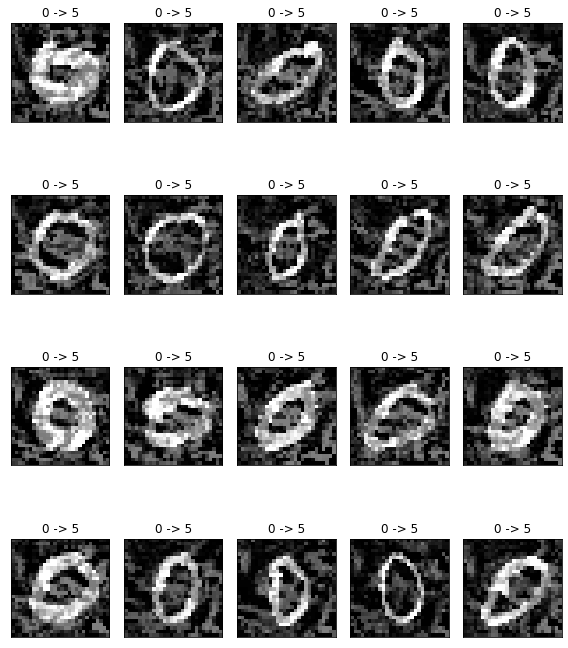

In [14]:
fgsm = FGSM(orinal_num=0, target_num=5)
fgsm.start_fgsa()
fgsm.display_results()